# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [13]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
from sklearn.metrics import log_loss
%matplotlib inline

In [7]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [8]:
heart_df=pd.read_csv("framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [9]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

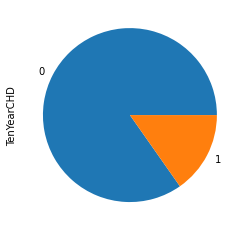

In [ ]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [10]:
x = heart_df.values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
heart_df_scaled = pd.DataFrame(x_scaled, columns=heart_df.columns) # Conversión a un DataFrame #

In [11]:
x = heart_df_scaled.iloc[:,:-1]
y = heart_df_scaled.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [ ]:
logreg = LogisticRegression().fit(x_train,y_train)
y_pred = logreg.predict(x_test) 

score = accuracy_score(y_test,y_pred)
score2 = accuracy_score(y_test,y_pred,normalize=False)

print(f'Precisión inicial: {round(score*100,ndigits=2)}%')
print(f'Es decir predijo bien: {score2} de {y_test.size}')

Precisión inicial: 84.53%
Es decir predijo bien: 634 de 750


**Análisis**

Se puede observar que la precisión inicial del modelo es mayor al 80% lo cual es una buena aproximación. Sin embargo, no se puede olvidar que se tiene un set de **datos desbalanceado**, esto implica que esta medida del error no este mostrando el verdadero rendimiento del modelo.

### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

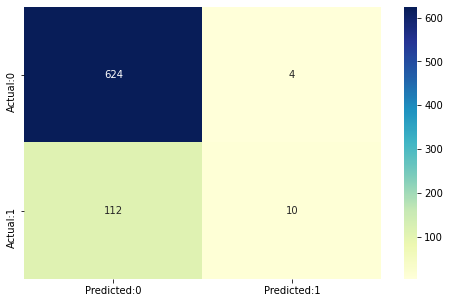

In [ ]:
import collections
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [ ]:
print(logreg.classes_) #Esto es para saber como organizo las clases el modelo.

[0. 1.]


In [ ]:
from sklearn.preprocessing import binarize

umbrales = np.random.rand(10)# Vector que Contiene los Umbrales a Analizar #

for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred2 = binarize(y_pred_prob_yes[:,1].reshape(-1,1),threshold=umbral)# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test,y_pred2)
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{np.array([['TN','FP'],['FN','TP']])}
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos negativo.
Recall: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Precision: {round(cm2[1,1]/(float(cm2[1,1]+cm2[0,1])), 4)}\n''')


->Para un umbral de 0.1674 tenemos esta matriz de confusión:
[['TN' 'FP']
 ['FN' 'TP']]
[[455 173]
 [ 45  77]]
Con 532 predicciones correctas y 45 falsos negativo.
Recall: 0.6311 Precision: 0.308

->Para un umbral de 0.8186 tenemos esta matriz de confusión:
[['TN' 'FP']
 ['FN' 'TP']]
[[628   0]
 [122   0]]
Con 628 predicciones correctas y 122 falsos negativo.
Recall: 0.0 Precision: nan

->Para un umbral de 0.4986 tenemos esta matriz de confusión:
[['TN' 'FP']
 ['FN' 'TP']]
[[624   4]
 [111  11]]
Con 635 predicciones correctas y 111 falsos negativo.
Recall: 0.0902 Precision: 0.7333

->Para un umbral de 0.1604 tenemos esta matriz de confusión:
[['TN' 'FP']
 ['FN' 'TP']]
[[442 186]
 [ 43  79]]
Con 521 predicciones correctas y 43 falsos negativo.
Recall: 0.6475 Precision: 0.2981

->Para un umbral de 0.5372 tenemos esta matriz de confusión:
[['TN' 'FP']
 ['FN' 'TP']]
[[625   3]
 [118   4]]
Con 629 predicciones correctas y 118 falsos negativo.
Recall: 0.0328 Precision: 0.5714

->Para un umbr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

0.7338806515610317

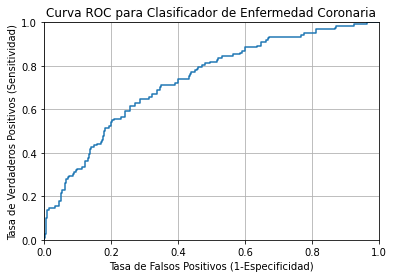

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

**Curva ROC**

Se conoce que cuanto mayor sea el AUC, mejor será el modelo para predecir la clase 0 como 0 y la clase 1 como 1 y, de la función calculada, este valor es de 0.73 lo que indica que a pesar de que no se tiene una cercanía a 1 posee cierta medida de separabilidad. De este modo, hay un 73% de posibilidades de que el modelo pueda distinguir entre la clase positiva y la clase negativa.

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [ ]:
np.random.seed(22)
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

#Este es un analisis de velocidad de convergencia.
En donde vamos a mirar el mismo modelo con el mismo Learning rate, para observar que diferencia obtenemos.

In [ ]:
random.seed(22)

X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values
y_train_array = y_train_array.reshape(-1,1)

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w#

w = w0.copy()
wi = w
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 0.39

def sigma(w,x):
  w = w.reshape(-1,1)
  res_sigmoid = 1/(1+np.exp(-np.dot(x,w)))
  return res_sigmoid

iter = 1000

aveItera = np.zeros((20,5))
tasas = np.arange(1,6,1,dtype=np.float64)
for h in range(20):
  w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w#
  w = w0.copy()
  for idx,tasa in enumerate(tasas):
    cont = 0
    errores = np.array([])
    error = 100
  
    while cont <= iter and error > eps:
      i = random.randint(0,X_train_array.shape[0]-1)
      x,y = X_train_array[i],y_train_array[i]
      g = sigma(w,x)
      e = y - g
      tasa = (10**-tasa)
      w1 = w + tasa*e*x

    #Calculo del error de entropia cruzada.
      pred = sigma(w1,X_train_array)
      error = log_loss(y_train_array,pred) 
      errores = np.append(errores,error)
    #Actualizaciòn de vector con los pesos.
      w = w1
      cont += 1
  
    aveItera[h,idx] = cont

    #Volver a colocar los w iniciales.
    w = w0

print(aveItera)
print("El promedio por tasa es")
print(np.array(["1e-1","1e-2","1e-3","1e-4","1e-5",]))
print(np.mean(aveItera,axis=0))
  

[[407. 651. 305. 416. 371.]
 [559. 800. 573. 468. 484.]
 [291. 803. 594. 464. 355.]
 [639. 484. 577. 831. 617.]
 [692. 364. 370. 439. 519.]
 [515. 592. 668. 696. 336.]
 [418. 334. 346. 748. 489.]
 [327. 534. 605. 463. 539.]
 [479. 673. 314. 197. 689.]
 [667. 489. 670. 414. 865.]
 [798. 856. 523. 585. 563.]
 [451. 393. 332. 659. 410.]
 [759. 360. 449. 498. 378.]
 [513. 296. 420. 294. 463.]
 [101. 368. 543. 306. 205.]
 [515. 928. 603. 271. 679.]
 [430. 302. 364. 712. 556.]
 [543. 399. 682. 529. 505.]
 [833. 495. 928. 627. 569.]
 [481. 739. 397. 265. 508.]]
El promedio por tasa es
['1e-1' '1e-2' '1e-3' '1e-4' '1e-5']
[520.9  543.   513.15 494.1  505.  ]


Despues de realizar varias iteraciones, no parece haber un valor exacto del learning rate que nos asegure que va a converger mas rapido que los otros, sin embargo se aprecia que los mejores resultados siempre estuvieron entre '1e-3' y '1e-4', por lo que se toma '1e-3' para el siguiente analisis.

0.4006727781347989 0.3870862588759111


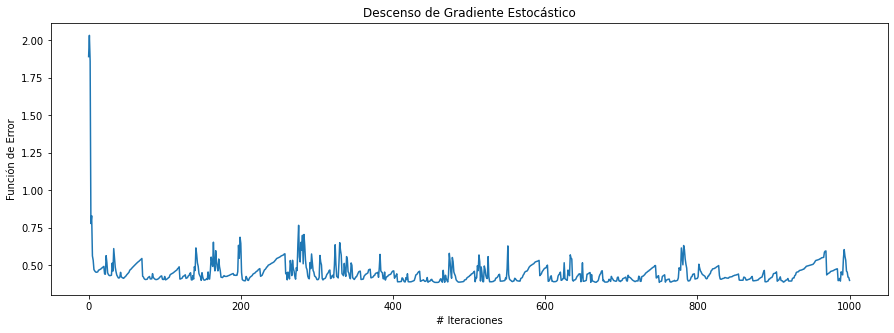

In [ ]:
from sklearn.metrics import log_loss
np.random.seed(22)
random.seed(22)

X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values
y_train_array = y_train_array.reshape(-1,1)

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #

w = w0.copy()
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-3
error = 100

def sigma(w,x):
  w = w.reshape(-1,1)
  res_sigmoid = 1/(1+np.exp(-np.dot(x,w)))
  return res_sigmoid

iter = 1000

tasa = 3

cont = 0
errores = np.array([])
while cont <= iter and error > eps:
  i = random.randint(0,X_train_array.shape[0]-1)
  x,y = X_train_array[i],y_train_array[i]
  g = sigma(w,x)
  e = y - g
  tasa = (10**-tasa)
  w1 = w + tasa*e*x

  #Calculo del error de entropia cruzada.
  pred = sigma(w1,X_train_array)
  error = log_loss(y_train_array,pred) 
  errores = np.append(errores,error)
  #Actualizaciòn de vector con los pesos.
  w = w1
  cont += 1

plt.figure(figsize=(15,5))
plt.plot(errores)
plt.xlabel('# Iteraciones')
plt.ylabel('Función de Error')
plt.title('Descenso de Gradiente Estocástico')
print(errores[-1],np.amin(errores))

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

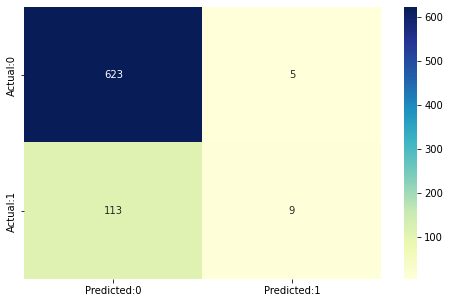

In [ ]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

**Cálculos matriz de confusión**

In [ ]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
Precision=(TP)/float(TP+FP)
Recall=(TP)/float(TP+FN)
Accuracy=(TP+TN)/float(TP+TN+FP+FN)
print('Precision=', Precision)
print('Recall=',Recall)
print('Accuracy=',Accuracy)
print('F-measure=',(2*Recall*Precision)/float(Recall+Precision))

Precision= 0.6428571428571429
Recall= 0.07377049180327869
Accuracy= 0.8426666666666667
F-measure= 0.1323529411764706


**Análisis de la matriz de confusión**

La matriz de confusión muestra 632 predicciones correctas y 118 predicciones incorrectas. De esta manera se tiene que:

* Positivos verdaderos: 9
* Negativos verdaderos: 623
* Error tipo I (falsos positivos): 5 
* Error tipo II (falsos negativos): 113

 Del *recall* se puede observar que de todas las clases posibles, se predijeron correctamente 0.073. Lo cual es un mal indicador, ya que nuestro modelo no identifica bien cuando son positivos. 

 Del *precision* se puede decir que de todas las clases que se predijeron como positivas, las que son verdaderamente positivas son 0.64. A pesar de que este valor no es tan cercano a 1, es una aproximación satisfactoria. 

 Del *accuracy* se puede concluir que de todas las clases (positivas y negativas), se predijeron correctamente 0.84. 

 Finalmente, del *F-measure* se comparan al tiempo *recall* y *precision* siendo este 0.13. 


Por lo tanto se decide hacer un analisis de umbralización, para apreciar si se puede llegar a mejorar el modelo, entendiendo que para cuestiones medicas, es importante tener un *recall* alto, ya que se requiere identificar los casos positivos.

#Analisis con umbralización

In [17]:
np.random.seed(22)
random.seed(22)

X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values
y_train_array = y_train_array.reshape(-1,1)

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w#

w = w0.copy()
wi = w
# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 0.39

def sigma(w,x):
  w = w.reshape(-1,1)
  res_sigmoid = 1/(1+np.exp(-np.dot(x,w)))
  return res_sigmoid

iter = 1000

umbrales = np.arange(0.0,1.0,0.1)
tasa = 3
cont = 0
error = 100
errores = np.array([])

while cont <= iter and error > eps:
  i = random.randint(0,X_train_array.shape[0]-1)
  x,y = X_train_array[i],y_train_array[i]
  g = sigma(w,x)
  e = y - g
  tasa = (10**-tasa)
  w1 = w + tasa*e*x

    #Calculo del error de entropia cruzada.
  pred = sigma(w1,X_train_array)
  error = log_loss(y_train_array,pred) 
  errores = np.append(errores,error)
    #Actualizaciòn de vector con los pesos.
  w = w1
  cont += 1

for umbral in umbrales:
  X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
  y_test_array = y_test.values

  y_pred = np.zeros(len(x_test))
  prob = sigma(w,X_test_array)
  y_pred = np.where(prob>umbral,1,0)

  cm = confusion_matrix(y_test,y_pred)
  TN=cm[0,0]
  TP=cm[1,1]
  FN=cm[1,0]
  FP=cm[0,1]

  Recall=(TP)/float(TP+FN)
  Precision=(TP)/float(TP+FP)
  F = (2*Recall*Precision)/float(Recall+Precision)

  print('\n')
  print(f'Para el umbral {umbral}')
  print(f'El Recall es igual a {Recall}')
  print(f'El f1_score es igual a {F}')



Para el umbral 0.0
El Recall es igual a 1.0
El f1_score es igual a 0.2798165137614679


Para el umbral 0.1
El Recall es igual a 0.8032786885245902
El f1_score es igual a 0.3414634146341463


Para el umbral 0.2
El Recall es igual a 0.4180327868852459
El f1_score es igual a 0.3669064748201438


Para el umbral 0.30000000000000004
El Recall es igual a 0.13114754098360656
El f1_score es igual a 0.20125786163522014


Para el umbral 0.4
El Recall es igual a 0.01639344262295082
El f1_score es igual a 0.03125


Para el umbral 0.5
El Recall es igual a 0.00819672131147541
El f1_score es igual a 0.016129032258064516


Para el umbral 0.6000000000000001
El Recall es igual a 0.0
El f1_score es igual a nan


Para el umbral 0.7000000000000001
El Recall es igual a 0.0
El f1_score es igual a nan


Para el umbral 0.8
El Recall es igual a 0.0
El f1_score es igual a nan


Para el umbral 0.9
El Recall es igual a 0.0
El f1_score es igual a nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


El umbral del 10%, parece ser un buen modelo.